In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models , layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
def is_image(name ,filename, verbose=False):

    data = open("/content/gdrive/MyDrive/Classification_Project/Micro_Organism/"+name+"/"+filename,'rb').read(10)

    # check if file is JPG or JPEG
    if data[:3] == b'\xff\xd8\xff':
        if verbose == True:
             print(filename+" is: JPG/JPEG.")
        return True

    # check if file is PNG
    if data[:8] == b'\x89\x50\x4e\x47\x0d\x0a\x1a\x0a':
        if verbose == True:
             print(filename+" is: PNG.")
        return True

    # check if file is GIF
    if data[:6] in [b'\x47\x49\x46\x38\x37\x61', b'\x47\x49\x46\x38\x39\x61']:
        if verbose == True:
             print(filename+" is: GIF.")
        return True

    return False


In [ ]:
import os

for name in os.listdir("/content/gdrive/MyDrive/Classification_Project/Micro_Organism"):
  for filename in os.listdir("/content/gdrive/MyDrive/Classification_Project/Micro_Organism/"+name):

    if is_image(name ,filename, verbose=False) == False:
        os.remove(os.path.join("/content/gdrive/MyDrive/Classification_Project/Micro_Organism/"+name, filename))

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=200
CHANNELS=3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory( "/content/gdrive/MyDrive/Classification_Project/Micro_Organism" ,
                                                             shuffle=True ,
                                                             image_size=(IMAGE_SIZE,IMAGE_SIZE) ,
                                                             batch_size=BATCH_SIZE
                                                            )

Found 799 files belonging to 8 classes.


In [ ]:
class_names= dataset.class_names
class_names

['Amoeba',
 'Euglena',
 'Hydra',
 'Paramecium',
 'Rod_bacteria',
 'Spherical_bacteria',
 'Spiral_bacteria',
 'Yeast']

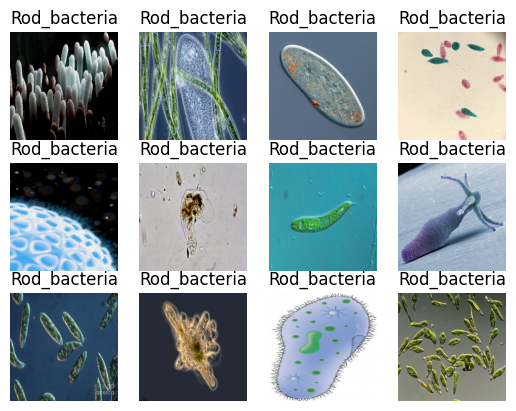

In [ ]:
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")


In [ ]:
def get_dataset_partitions(dataset, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(dataset_size * train_size)
    val_size = int(dataset_size * val_size)

    train_dataset = dataset.take(train_size)

    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_ds , val_ds , test_ds = get_dataset_partitions(dataset)

In [ ]:
len(train_ds) , len(val_ds) , len(test_ds)

(20, 2, 3)

In [ ]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape = (BATCH_SIZE , IMAGE_SIZE,IMAGE_SIZE , CHANNELS)
n_classes=8
model = models.Sequential([ resize_and_rescale , data_augmentation ,
                            layers.Conv2D(32,(3,3),activation='relu' , input_shape = input_shape),
                            layers.MaxPooling2D((2,2)),
                            layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
                            layers.MaxPooling2D ((2, 2)),
                            layers. Conv2D (64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers. Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers. Flatten(),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(n_classes , activation='softmax')
                        ])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile( optimizer='adam',
               loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy']
              )

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/200
20/20 [==============================] - 37s 733ms/step - loss: 2.0579 - accuracy: 0.2081 - val_loss: 2.0530 - val_accuracy: 0.2031
Epoch 2/200
20/20 [==============================] - 18s 606ms/step - loss: 1.9838 - accuracy: 0.1941 - val_loss: 1.9027 - val_accuracy: 0.2500
Epoch 3/200
20/20 [==============================] - 17s 601ms/step - loss: 1.9202 - accuracy: 0.2394 - val_loss: 1.9137 - val_accuracy: 0.2344
Epoch 4/200
20/20 [==============================] - 13s 369ms/step - loss: 1.8936 - accuracy: 0.2535 - val_loss: 1.8386 - val_accuracy: 0.2500
Epoch 5/200
20/20 [==============================] - 13s 403ms/step - loss: 1.8376 - accuracy: 0.2817 - val_loss: 1.8337 - val_accuracy: 0.2188
Epoch 6/200
20/20 [==============================] - 12s 327ms/step - loss: 1.8110 - accuracy: 0.3099 - val_loss: 1.5447 - val_accuracy: 0.4375
Epoch 7/200
20/20 [==============================] - 12s 350ms/step - loss: 1.7876 - accuracy: 0.3266 - val_loss: 1.7067 - val_accuracy:

In [ ]:
scores=model.evaluate(test_ds)
scores

3/3 [==============================] - 6s 45ms/step - loss: 0.3924 - accuracy: 0.8632


[0.39242300391197205, 0.8631578683853149]

In [ ]:
history.params

{'verbose': 1, 'epochs': 200, 'steps': 20}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc =history.history['val_accuracy']

loss= history.history['loss']
val_loss =history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

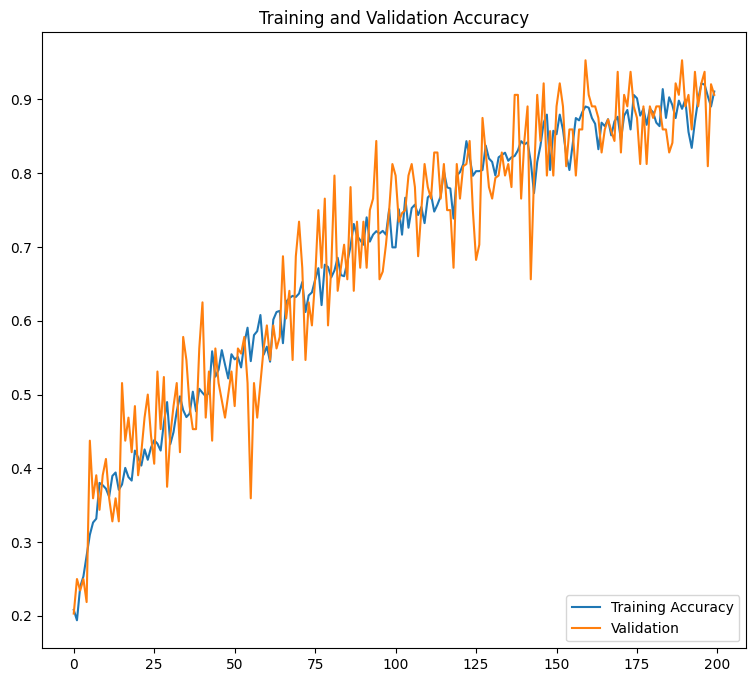

In [ ]:
plt. figure(figsize=(20, 8))
plt.subplot(1, 2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

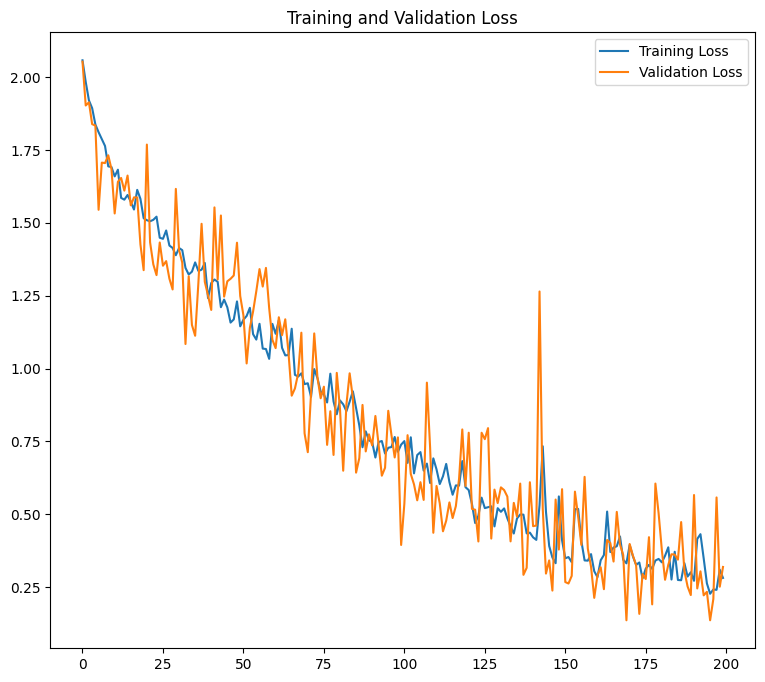

In [ ]:
plt. figure(figsize=(20, 8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: Euglena
1/1 [==============================] - 0s 145ms/step
Euglena


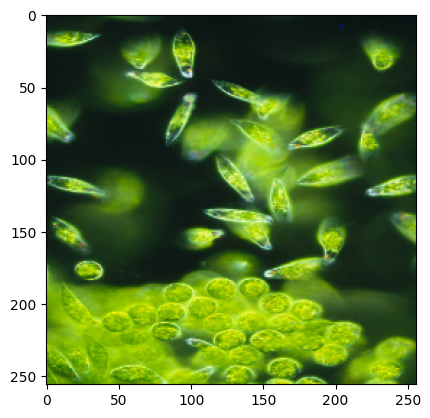

In [ ]:
for images_batch , labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label= labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:",class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print(class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model , img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  prediction_class = class_names[np.argmax(predictions[0])]
  confidence= round(100*(np.max(predictions[0])),2)
  return prediction_class , confidence

1/1 [==============================] - 0s 25ms/step


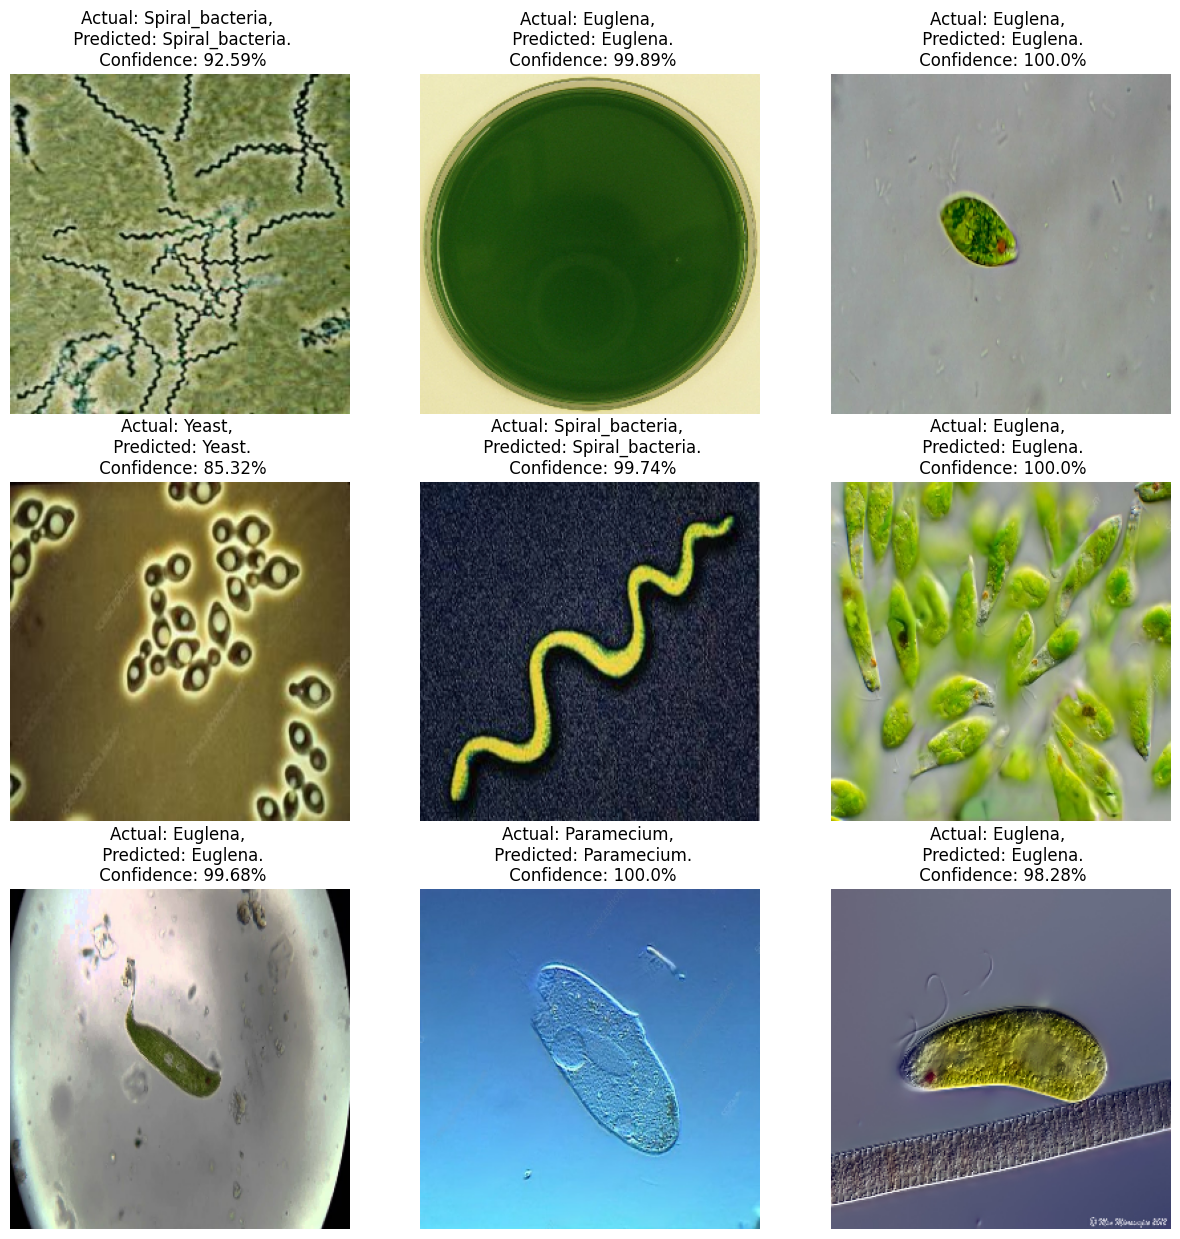

In [ ]:
plt.figure(figsize=(15,15))
for images , labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")


In [ ]:
model.save("My_model.keras")

In [ ]:
MODEL = tf.keras.models.load_model("/content/gdrive/MyDrive/Classification_Project/My_model.keras")

In [ ]:
tf.__version__

'2.15.0'